In [24]:
import jax
import jax.numpy as jnp
from jax import lax

interior_slice = slice(1, -1), slice(1, -1)


def compute_laplacian_2d(array, dx=1.0, dy=1.0):
    laplacian = jnp.zeros_like(array)
    laplacian = laplacian.at[interior_slice].set(
        (array[:-2, 1:-1] - 2 * array[1:-1, 1:-1] + array[2:, 1:-1]) / (dx * dx)
        + (array[1:-1, :-2] - 2 * array[1:-1, 1:-1] + array[1:-1, 2:]) / (dy * dy)
    )
    return laplacian


def enforce_boundary_conditions(
    field: jnp.ndarray, region_mask: jnp.ndarray, rescaling_factor: float
):
    masked_field = field * region_mask
    smoothed_values = jnp.zeros_like(masked_field)
    smoothed_values = smoothed_values.at[1:, :].add(masked_field[:-1, :])
    smoothed_values = smoothed_values.at[:-1, :].add(masked_field[1:, :])
    smoothed_values = smoothed_values.at[:, 1:].add(masked_field[:, :-1])
    smoothed_values = smoothed_values.at[:, :-1].add(masked_field[:, 1:])
    smoothed_values *= rescaling_factor
    return smoothed_values


def simulate_diffusion(
    initial_field: jnp.ndarray,
    total_time: float,
    dt: float,
    diffusion_coefficient: float,
    region_mask: jnp.ndarray,
    rescaling_factor: float,
    dx: float = 1.0,
    dy: float = 1.0,
):

    def diffusion_step(
        field,
        _,
        diffusion_coefficient=diffusion_coefficient,
        dt=dt,
        region_mask=region_mask,
        rescaling_factor=rescaling_factor,
    ):
        # Enforce boundary conditions
        smoothed_values = enforce_boundary_conditions(
            field, region_mask, rescaling_factor
        )

        # Compute the Laplacian
        laplacian = compute_laplacian_2d(field * region_mask + smoothed_values, dx, dy)

        # Update field with diffusion term
        field += diffusion_coefficient * dt * laplacian

        return field, field

    n_total_steps = int(total_time / dt)

    _, field_ts = lax.scan(
        f=diffusion_step,
        init=initial_field,
        xs=None,
        length=n_total_steps,
    )

    return field_ts


def calculate_diffusion_coefficient(sigma, dt):
    return (sigma**2) / (2 * dt)


def calculate_minimum_grid_spacing(sigma):
    return sigma * jnp.sqrt(2)

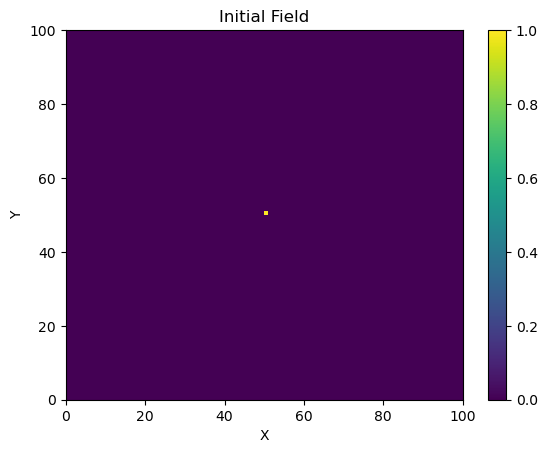

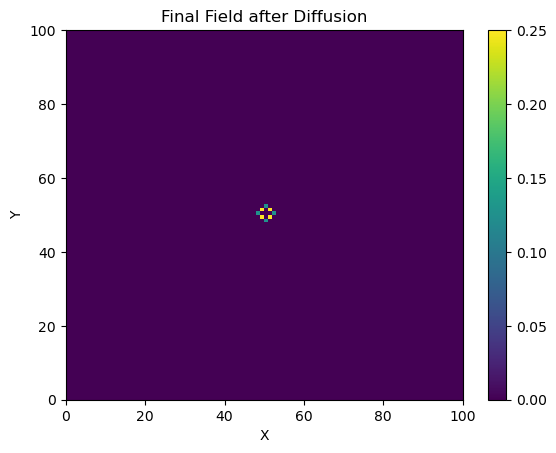

In [55]:
import matplotlib.pyplot as plt

# Define region_mask and rescaling_factor as jax arrays
region_mask = jnp.ones((100, 100))
rescaling_factor = (
    jnp.ones_like(region_mask) / 4.0
)  # Normalize by the number of neighbors (4 in this case)

# Initialize some initial condition for the field
initial_field = jnp.zeros_like(region_mask)
initial_field = initial_field.at[
    region_mask.shape[0] // 2, region_mask.shape[1] // 2
].set(
    1.0
)  # Set a single point with high value

# Define simulation parameters
total_time = 1.00
dt = 0.001

desired_standard_deviation = jnp.sqrt(6.0)  # Desired standard deviation of the Gaussian

# Calculate diffusion coefficient and grid spacing
diffusion_coefficient = calculate_diffusion_coefficient(desired_standard_deviation, dt)
dy = dx = calculate_minimum_grid_spacing(desired_standard_deviation)
dx = dy = desired_standard_deviation


# Run the diffusion simulation
field_ts = simulate_diffusion(
    initial_field,
    total_time,
    dt,
    diffusion_coefficient,
    region_mask,
    rescaling_factor,
    dx=dx,
    dy=dy,
)


# Visualization
def plot_field(field, title):
    x, y = jnp.meshgrid(
        jnp.arange(field.shape[1]) * dx, jnp.arange(field.shape[0]) * dy
    )
    plt.pcolormesh(field, cmap="viridis", vmin=0)
    plt.colorbar()
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()


# Plot initial field
plot_field(initial_field, "Initial Field")

# Plot final field
plot_field(field_ts[0], "Final Field after Diffusion")

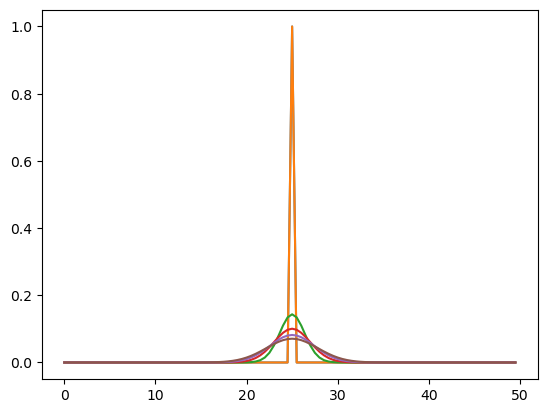

In [219]:
import numpy as np

dx = 0.5
state_x = np.arange(0, 50, dx)
n_states = state_x.shape[0]


initial_state = np.zeros((n_states,))
initial_state[initial_state.shape[0] // 2] = 1.0


plt.plot(state_x, initial_state, label="Initial State")

diffusion_coefficient = 0.5
dt = 0.001
total_time = 10.0

n_total_steps = int(total_time / dt)

u = np.zeros((n_total_steps, n_states))
u[0] = initial_state

diffusion_constant = diffusion_coefficient * dt / (dx**2)

d = np.zeros((n_states,))

for n in range(n_total_steps - 1):
    # for i in range(1, n_states-2):
    #     u[n + 1, i] = u[n, i] + diffusion_constant * (
    #         (u[n, i + 1] - u[n, i]) + (u[n, i - 1] - u[n, i])
    #     )
    u[n + 1, slice(1, -1)] = u[n, slice(1, -1)] + diffusion_constant * (
        u[n, 2:] - 2 * u[n, 1:-1] + u[n, :-2]
    )

plt.plot(state_x, u[::2000].T)

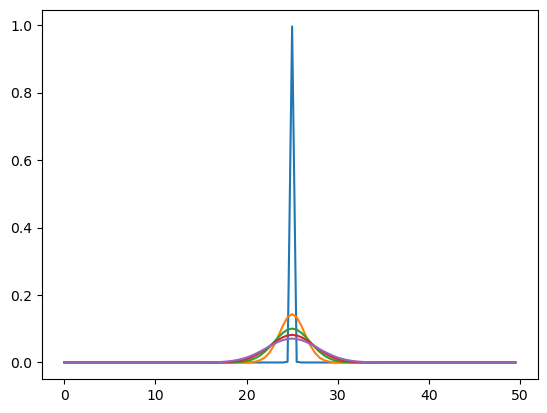

In [223]:
dx = 0.5
state_x = np.arange(0, 50, dx)
n_states = state_x.shape[0]

initial_state = np.zeros((n_states,))
initial_state[initial_state.shape[0] // 2] = 1.0

diffusion_coefficient = 0.5
dt = 0.001
total_time = 10.0

n_total_steps = int(total_time / dt)


def _step(u_t, _):
    u_t = u_t.at[slice(1, -1)].set(
        u_t[slice(1, -1)] + diffusion_constant * (u_t[2:] - 2 * u_t[1:-1] + u_t[:-2])
    )
    return u_t, u_t


_, u_ts = lax.scan(
    f=_step,
    init=initial_state,
    xs=None,
    length=n_total_steps,
)

plt.plot(state_x, u_ts[::2000].T)

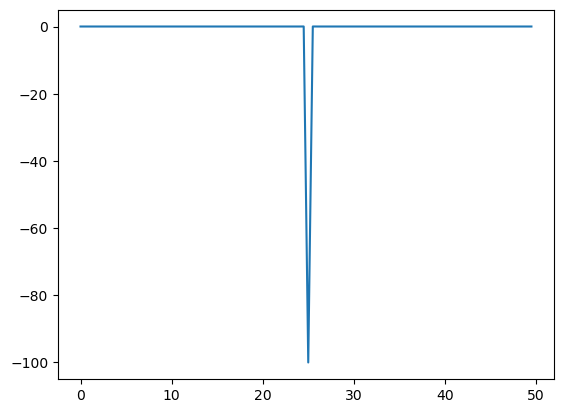

In [242]:
def impulse(x, x0, sigma):
    return jnp.exp(-((x - x0) ** 2) / (2 * sigma**2))


dd_impluse = jax.vmap(
    jax.grad(jax.grad(impulse, argnums=0), argnums=0), in_axes=(0, None, None)
)

plt.plot(state_x, dd_impluse(state_x, 25, 0.1))

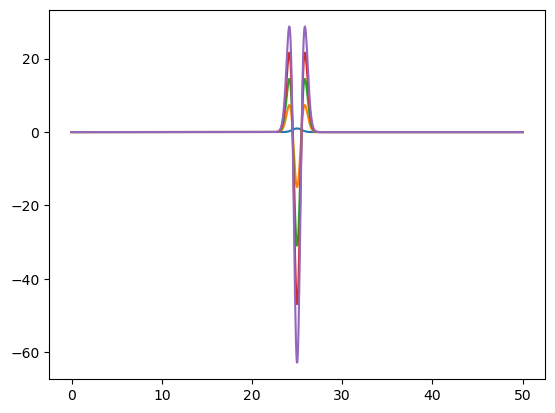

In [283]:
diffusion_coefficient = 0.5
dt = 0.001
total_time = 10.0

n_total_steps = int(total_time / dt)

dd_impluse = jax.vmap(
    jax.grad(jax.grad(impulse, argnums=0), argnums=0), in_axes=(0, None, None)
)

impulse_mean = 25
impulse_sigma = 0.5


def _step(u_t, _):
    u_t += diffusion_constant * dd_impluse(state_x, impulse_mean, impulse_sigma)
    return u_t, u_t


_, u_ts = lax.scan(
    f=_step,
    init=impulse(state_x, impulse_mean, impulse_sigma),
    xs=None,
    length=n_total_steps,
)

plt.plot(state_x, u_ts[::2000].T)

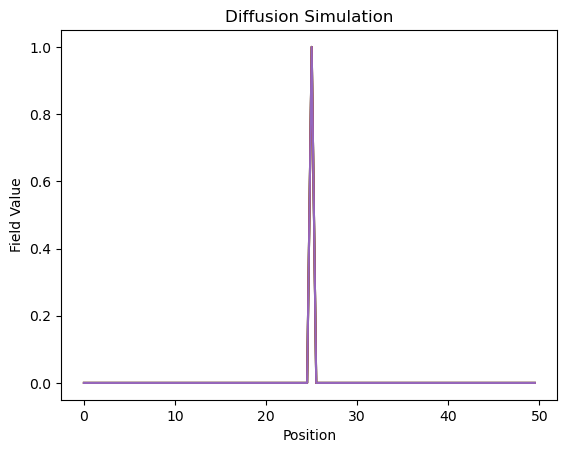

In [301]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import lax


# Define a function to compute the Laplacian in 1D using the second derivative
def compute_laplacian_1d(u):
    def wrapped_u(i):
        return u[jnp.astype(i, jnp.int32)]

    second_derivative = jax.vmap(jax.grad(jax.grad(wrapped_u)))
    index = jnp.arange(len(u)).astype(jnp.float32)

    return second_derivative(index)


dx = 0.5
state_x = np.arange(0, 50, dx)
n_states = state_x.shape[0]

initial_state = np.zeros((n_states,))
initial_state[initial_state.shape[0] // 2] = 1.0

diffusion_coefficient = 0.5
dt = 0.001
total_time = 10.0

n_total_steps = int(total_time / dt)


def _step(u_t, _):
    u_t += diffusion_coefficient * compute_laplacian_1d(u_t)
    return u_t, u_t


# Perform the simulation
_, u_ts = lax.scan(
    f=_step,
    init=initial_state,
    xs=None,
    length=n_total_steps,
)

# Plot results at intervals
plt.plot(state_x, u_ts[::2000].T)
plt.xlabel("Position")
plt.ylabel("Field Value")
plt.title("Diffusion Simulation")
plt.show()

In [305]:
from typing import Callable
from jax.scipy.optimize import minimize


def laplace(f: Callable, x0: jnp.ndarray) -> jnp.ndarray:
    mode, *details = minimize(lambda x: -f(x), x0, method="BFGS")
    H = jax.hessian(f)(mode)
    return mode, H


laplace(lambda x: x[0] ** 2 + x[1] ** 2, jnp.array([1.0, 1.0]))

(Array([1., 1.], dtype=float32),
 Array([[2., 0.],
        [0., 2.]], dtype=float32))

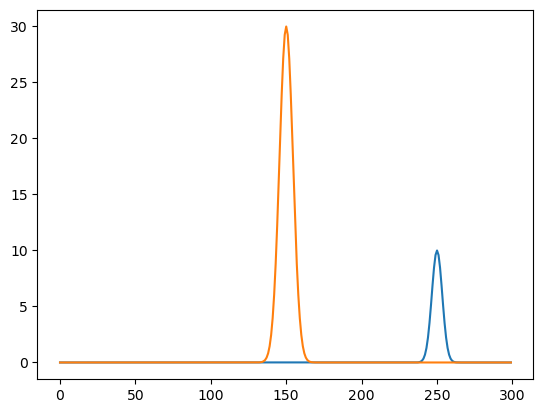

In [331]:
def receptive_field_model(
    position: np.ndarray, log_max_rate: float, place_field_center: float, scale: float
):
    return jnp.exp(log_max_rate - (position - place_field_center) ** 2 / (2 * scale**2))


position = np.arange(0, 300, 1)
plt.plot(position, receptive_field_model(position, np.log(10), 250.0, np.sqrt(12)))
plt.plot(position, receptive_field_model(position, np.log(30), 150.0, np.sqrt(20)))

F = np.identity(3)
Q = np.diag([1e-5, 1e-3, 1e-4])
dt = 0.020  # seconds

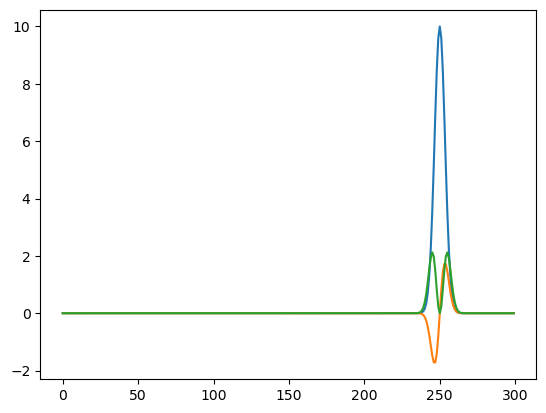

In [328]:
grad_receptive_field_model = jax.grad(receptive_field_model, argnums=(1, 2, 3))
hess_receptive_field_model = jax.hessian(receptive_field_model, argnums=(1, 2, 3))

plt.plot(
    position,
    [grad_receptive_field_model(x, np.log(10), 250.0, np.sqrt(12)) for x in position],
)
# hess_receptive_field_model(250.0, np.log(10), 250.0, np.sqrt(12))

[1.0, -0.41666666666666674, 0.6014065304058602]

In [371]:
def log_receptive_field_model(
    position: np.ndarray, params: tuple[float, float, float]
) -> np.ndarray:
    log_max_rate, place_field_center, scale = params
    return log_max_rate - (position - place_field_center) ** 2 / (2 * scale**2)


log_max_rate = np.log(10)
place_field_center = 250.0
scale = np.sqrt(12)
x = 245.0

grad_log_receptive_field_model = jax.grad(log_receptive_field_model, argnums=1)
np.allclose(
    grad_log_receptive_field_model(x, (log_max_rate, place_field_center, scale)),
    [
        1.0,
        (scale**-2) * (x - place_field_center),
        (scale**-3) * (x - place_field_center) ** 2,
    ],
)

hess_log_receptive_field_model = jax.hessian(log_receptive_field_model, argnums=1)
jnp.allclose(
    jnp.array(
        hess_log_receptive_field_model(x, (log_max_rate, place_field_center, scale))
    ),
    jnp.array(
        [
            [0, 0, 0],
            [0, -(scale**-2), -2 * scale**-3 * (x - place_field_center)],
            [
                0,
                -2 * scale**-3 * (x - place_field_center),
                -3 * scale**-4 * (x - place_field_center) ** 2,
            ],
        ]
    ),
)

Array(True, dtype=bool)

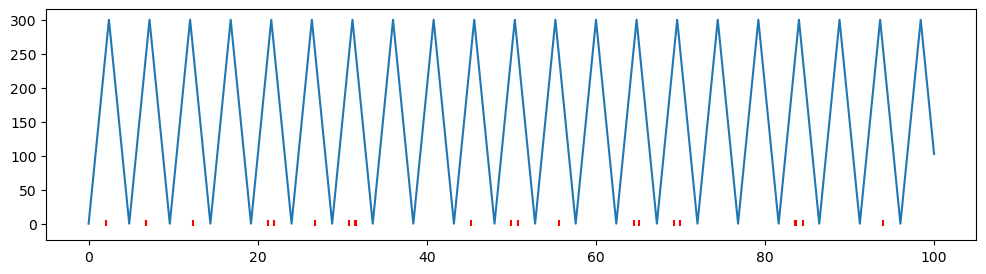

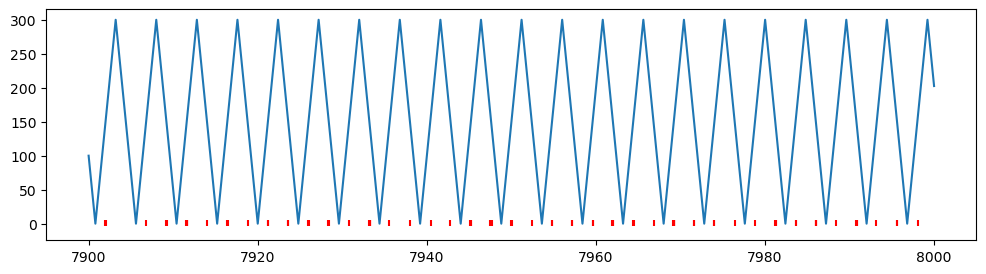

In [472]:
def log_receptive_field_model(
    position: np.ndarray, params: tuple[float, float, float]
) -> np.ndarray:
    log_max_rate, place_field_center, scale = params
    return log_max_rate - (position - place_field_center) ** 2 / (2 * scale**2)


def receptive_field_model(
    position: np.ndarray, params: tuple[float, float, float]
) -> np.ndarray:
    return jnp.exp(log_receptive_field_model(position, params))


grad_log_receptive_field_model = jax.grad(log_receptive_field_model, argnums=1)
hess_log_receptive_field_model = jax.hessian(log_receptive_field_model, argnums=1)


dt = 0.020  # seconds
total_time = 8000.0  # seconds
n_total_steps = int(total_time / dt)

time = np.arange(0, total_time, dt)

speed = 125.0  # cm/s
track_length = 300.0  # cm

run1 = np.arange(0, track_length, speed * dt)
run2 = np.arange(track_length, 0, -speed * dt)
run = np.concatenate((run1, run2))

position = np.concatenate([run] * int(np.ceil(n_total_steps / run.shape[0])))
position = position[:n_total_steps]

true_params1 = (np.log(10), 250.0, np.sqrt(12))
true_params2 = (np.log(30), 150.0, np.sqrt(20))
true_rate1 = receptive_field_model(position[: position.shape[0] // 2], true_params1)
true_rate2 = receptive_field_model(position[position.shape[0] // 2 :], true_params2)
true_rate = np.concatenate((true_rate1, true_rate2))
spike_indicator = np.random.poisson(true_rate * dt)

plt.figure(figsize=(12, 3))
plt.plot(time[:5_000], position[:5_000])
plt.eventplot(time[spike_indicator[:5_000].nonzero()[0]], color="red", linelengths=10.0)
plt.figure(figsize=(12, 3))
plt.plot(time[-5_000:], position[-5_000:])

plt.eventplot(
    time[(spike_indicator.shape[0] - 5000) + spike_indicator[-5_000:].nonzero()[0]],
    color="red",
    linelengths=10.0,
)

<function __main__.<lambda>(position, params)>

(0.0, 300.0)

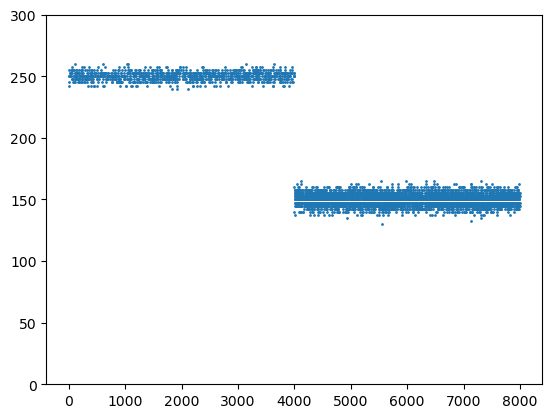

In [482]:
plt.scatter(
    time[spike_indicator.nonzero()[0]], position[spike_indicator.nonzero()[0]], s=1
)
plt.ylim((0, 300))

In [463]:
# random walk
transition_matrix = np.identity(3)
covariance_matrix = np.diag([1e-5, 1e-3, 1e-4])

params_prev = np.array((np.log(10), 250.0, np.sqrt(12)))
one_step_mean = transition_matrix @ params_prev

t = 0
conditional_intensity = receptive_field_model(position[t], one_step_mean)
innovation = spike_indicator[t] - conditional_intensity * dt
one_step_grad = grad_log_receptive_field_model(position[t], one_step_mean)[None]
one_step_hess = hess_log_receptive_field_model(position[t], one_step_mean)

In [465]:
one_step_grad.T @ one_step_grad

Array([[ 1.0000000e+00, -2.0833334e+01,  1.5035162e+03],
       [-2.0833334e+01,  4.3402780e+02, -3.1323256e+04],
       [ 1.5035162e+03, -3.1323256e+04,  2.2605610e+06]], dtype=float32)

In [458]:
innovation

Array(0., dtype=float32)

In [544]:
def point_process_adaptive_filter(
    init_params,
    x,
    spike_indicator,
    dt,
    transition_matrix,
    covariance_matrix,
    receptive_field_model,
    grad_log_receptive_field_model,
    hess_log_receptive_field_model,
):

    def _update(params_prev, args):
        """Point Process Adaptive Filter update step

        F : transition matrix
        Q : covariance matrix
        \theta_{k | k-1} :
        W_{k | k-1}: one_step_variance_params
        \theta_{k | k} : posterior_mean
        W_{k | k} : posterior_variance
        """
        mean_prev, variance_prev = params_prev
        x_t, spike_indicator_t = args
        one_step_mean = transition_matrix @ mean_prev
        one_step_variance = (
            transition_matrix @ variance_prev @ transition_matrix.T + covariance_matrix
        )
        conditional_intensity = receptive_field_model(x_t, one_step_mean) * dt
        innovation = spike_indicator_t - conditional_intensity
        one_step_grad = grad_log_receptive_field_model(x_t, one_step_mean)[None]
        one_step_hess = hess_log_receptive_field_model(x_t, one_step_mean)

        inverse_posterior_variance = (
            jnp.linalg.pinv(one_step_variance)
            + (one_step_grad.T * conditional_intensity @ one_step_grad)
            - innovation * one_step_hess
        )
        posterior_variance = jnp.linalg.pinv(inverse_posterior_variance)
        posterior_mean = one_step_mean + posterior_variance @ (
            one_step_grad.squeeze() * innovation
        )

        return (posterior_mean, posterior_variance), (
            posterior_mean,
            posterior_variance,
        )

    return jax.lax.scan(_update, init_params, (x, spike_indicator))[1]


(
    posterior_mean,
    posterior_variance,
) = point_process_adaptive_filter(
    (np.array(true_params1), np.identity(3)),
    position,
    spike_indicator,
    dt,
    transition_matrix,
    covariance_matrix,
    receptive_field_model,
    grad_log_receptive_field_model,
    hess_log_receptive_field_model,
)

Text(0.5, 0.98, 'Stochastic State Point Process Filter (SSPPF)')

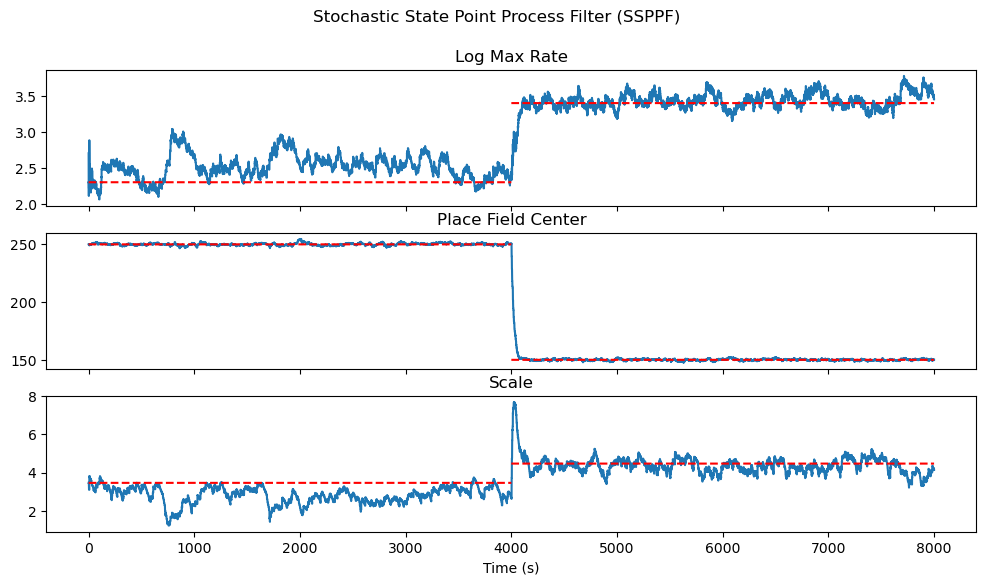

In [545]:
def plot_results(time, true_params1, true_params2, posterior_mean):
    fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True)
    axes[0].plot(time, posterior_mean[:, 0])
    axes[0].plot(
        time[:time.shape[0] // 2],
        true_params1[0] * np.ones_like(time[:time.shape[0] // 2]),
        linestyle="--", color="red"
    )
    axes[0].plot(
        time[time.shape[0] // 2 :],
        true_params2[0] * np.ones_like(time[time.shape[0] // 2 :]),
        linestyle="--", color="red"
    )
    axes[0].set_title("Log Max Rate")
    axes[1].plot(time, posterior_mean[:, 1])
    axes[1].plot(
        time[:time.shape[0] // 2],
        true_params1[1] * np.ones_like(time[:time.shape[0] // 2]),
        linestyle="--", color="red"
    )
    axes[1].plot(
        time[time.shape[0] // 2 :],
        true_params2[1] * np.ones_like(time[time.shape[0] // 2 :]),
        linestyle="--", color="red"
    )
    axes[1].set_title("Place Field Center")
    axes[2].plot(time, posterior_mean[:, 2])
    axes[2].plot(
        time[:time.shape[0] // 2],
        true_params1[2] * np.ones_like(time[:time.shape[0] // 2]),
        linestyle="--", color="red"
    )
    axes[2].plot(
        time[time.shape[0] // 2 :],
        true_params2[2] * np.ones_like(time[time.shape[0] // 2 :]),
        linestyle="--", color="red"
    )
    axes[2].set_title("Scale")
    axes[-1].set_xlabel("Time (s)")

plot_results(time, true_params1, true_params2, posterior_mean)
plt.suptitle("Stochastic State Point Process Filter (SSPPF)")

Text(0.5, 0.98, 'Steepest Descent Point Process Filter (SDPPF)')

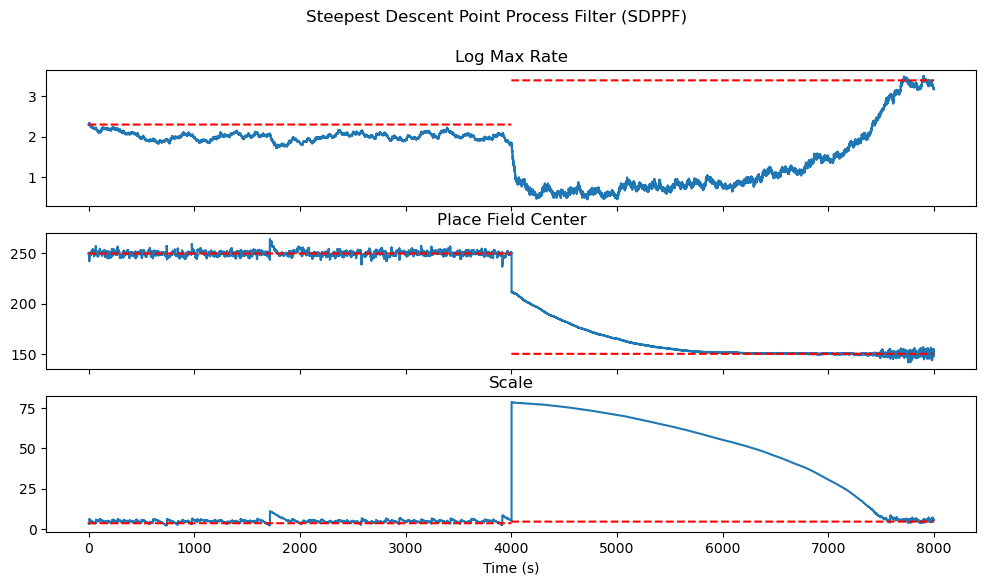

In [542]:
def steepest_descent_point_process_filter(
    init_params,
    x,
    spike_indicator,
    dt,
    receptive_field_model,
    grad_log_receptive_field_model,
    epsilon,
):

    def _update(mean_prev, args):
        """Steepest Descent Point Process Filter update step"""

        x_t, spike_indicator_t = args
        conditional_intensity = receptive_field_model(x_t, mean_prev) * dt
        innovation = spike_indicator_t - conditional_intensity
        one_step_grad = grad_log_receptive_field_model(x_t, mean_prev)
        posterior_mean = mean_prev + epsilon @ one_step_grad * innovation

        return posterior_mean, posterior_mean

    return jax.lax.scan(_update, init_params, (x, spike_indicator))[1]

epsilon = np.diag([0.02, 10.0, 1.0])

posterior_mean2 = steepest_descent_point_process_filter(
    np.array(true_params1),
    position,
    spike_indicator,
    dt,
    receptive_field_model,
    grad_log_receptive_field_model,
    epsilon,
)

plot_results(time, true_params1, true_params2, posterior_mean2)
plt.suptitle("Steepest Descent Point Process Filter (SDPPF)")

In [541]:
true_params1

(2.302585092994046, 250.0, 3.4641016151377544)

In [478]:
epsilon

array([[ 0.02,  0.  ,  0.  ],
       [ 0.  , 10.  ,  0.  ],
       [ 0.  ,  0.  ,  1.  ]])